# Evaluate the Effect of Temperature
See how the void growth rates and mobility terms change as a function of temperature

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import json

## Load Results
Each of the result folders in [the void tracking directory](../1_void-tracking) are named after the temperature and contain a file which contains the void growth and mobility functions.

In [2]:
param_order = ['alpha.0', 'alpha.1', 'beta.0', 'beta.1']  # The terms are always in the same order.

In [3]:
dynamics_terms = []
for path in Path('../1_void-tracking/output/').glob('8bitTIFF-*/growth-parameters-bayesian.json'):
    # Get the temperature
    temperature = float(path.parent.name.split("-")[-1][:-1])  # Directories are named [...]-[temp]C
    terms = {'temp': temperature}
    
    # Load the model parameters
    params = json.loads(path.read_text())
    for key, p in params.items():
        p = p['linear']  # Assume a linear model
        for name, v in zip(param_order, p['mean']):
            terms[f'{key}.{name}'] = v
        terms[f'{key}.covar'] = np.array(p['covar'])
    
    dynamics_terms.append(terms)
dynamics_terms = pd.DataFrame(dynamics_terms).sort_values('temp')

In [4]:
dynamics_terms

,temp,growth.alpha.0,growth.alpha.1,growth.beta.0,growth.beta.1,growth.covar,movement.alpha.0,movement.alpha.1,movement.beta.0,movement.beta.1,movement.covar
0,525.0,-0.011557,0.001143,-1.324878,-0.179344,"[[4.8161764081837156e-08, -6.302324349413257e-...",-3.129296,-0.472385,0.010736,-0.028414,"[[0.0005363390426832504, -8.948161232052568e-0..."
4,550.0,-0.022258,0.002240,-1.214464,-0.137394,"[[1.9134134381731594e-06, -2.946017025995168e-...",-3.140511,0.152452,0.291388,0.006986,"[[0.049168670609781674, -0.009072381140225122,..."
2,575.0,-0.001972,0.000388,-1.287720,-0.148187,"[[9.92291592452653e-08, -1.1115566817462613e-0...",-4.376133,-0.242392,-0.145051,0.013092,"[[0.0012552478923037787, -0.000165997214589149..."
5,600.0,0.001668,0.000323,-0.578453,-0.066384,"[[1.1975346361058786e-05, -1.4827310397220444e...",-1.853782,-0.114589,0.215395,0.010872,"[[0.003258948672497223, -0.0004996011167797161..."
3,625.0,0.004307,0.000186,-1.736480,-0.075090,"[[7.343414626138834e-09, -7.373434394053427e-1...",-3.434619,-0.302894,0.049303,-0.005710,"[[8.276516162400232e-05, -1.1533670985922519e-..."
1,650.0,0.014822,-0.000788,-1.773001,-0.075690,"[[4.0827574305371885e-08, -3.5946248201045516e...",-4.238290,-0.150949,-0.048074,-0.001573,"[[0.002078493657036105, -0.0002071492680966665..."


## Plot the Effect of Temperature on Growth
See if there is a consistent trend.

Compute the error bar for the growth rate knowing that the terms are additive

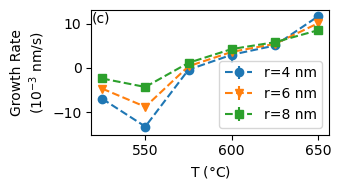

In [5]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

for r, m in zip([4, 6, 8], 'ovs'):
    y = dynamics_terms['growth.alpha.0'] + r * dynamics_terms['growth.alpha.1']
    yerr = np.sqrt(
        dynamics_terms['growth.covar'].apply(lambda x: x[0, 0]) + 
        dynamics_terms['growth.covar'].apply(lambda x: x[1, 1]) * r ** 2 +
        2 * r * dynamics_terms['growth.covar'].apply(lambda x: x[0, 1])
    )
    
    ax.errorbar(dynamics_terms['temp'],
                y=y * 1e3, yerr=yerr * 1e3,
               fmt=f'--{m}', label=f'r={r} nm')

ax.text(0, 0.9, '(c)', transform=ax.transAxes, fontsize=10)
ax.set_xlabel('T ($\\degree$C)')
ax.set_ylabel('Growth Rate\n($10^{-3}$ nm/s)')
ax.legend()
#ax.set_ylim(-0.02, 0.02)

fig.tight_layout()
fig.savefig('figures/growth-vs-temperature.png', dpi=320)

Notes:
- We are less confident in the 525C voids because they are in a different imaging mode. Mention that in the report

## Plot effect on Critical Radius
The critical radius is where the growth rate is zero

$r_{crit} = - \alpha_0 / \alpha_1$

We can express the variance of this term as: 

$\sigma_{r_{crit}}^2 = \left(\frac{\alpha_0}{\alpha_1}\right)^2 \left[ 
   \left(\frac{\sigma_{\alpha_0}}{\alpha_0} \right) ^ 2 +
   \left(\frac{\sigma_{\alpha_1}}{\alpha_1} \right) ^ 2 -
   2 \frac{\sigma_{\alpha_0\alpha_1}}{\alpha_0\alpha_1}
\right]$

through [propogation of uncertainty](https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Example_formulae)

In [6]:
dynamics_terms['radius_crit'] = -dynamics_terms['growth.alpha.0'] / dynamics_terms['growth.alpha.1']

In [7]:
dynamics_terms['radius_crit-std'] = dynamics_terms['radius_crit'] ** 2 * (
    dynamics_terms['growth.covar'].apply(lambda x: x[0, 0]) / dynamics_terms['growth.alpha.0'] ** 2 +
    dynamics_terms['growth.covar'].apply(lambda x: x[1, 1]) / dynamics_terms['growth.alpha.1'] ** 2 -
    2 * dynamics_terms['growth.covar'].apply(lambda x: x[0, 1]) / dynamics_terms['growth.alpha.1'] / dynamics_terms['growth.alpha.0']
)
dynamics_terms['radius_crit-std'] = np.sqrt(dynamics_terms['radius_crit-std'])

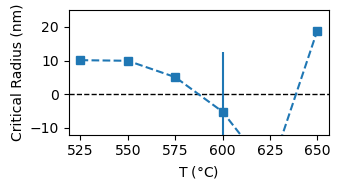

In [8]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.errorbar(dynamics_terms['temp'],
            y=dynamics_terms['radius_crit'],
            yerr=dynamics_terms['radius_crit-std'], 
            fmt=f'--{m}', label=f'r={r} nm')

ax.set_xlim(ax.get_xlim())
ax.plot(ax.get_xlim(), [0, 0], 'k--', lw=1)

ax.set_ylim(-12, 25)
ax.set_xlabel('T ($\\degree$C)')
ax.set_ylabel('Critical Radius (nm)')

fig.tight_layout()
fig.savefig('figures/critical-radius-vs-temperature.png', dpi=320)

I wonder what a negative critical radius means? All voids will grow continually? 
- It means voids, regardless of size, will grow or shrink
- Are we gradually decreasing in size. Radius for left is too large to detect, right is too small

Notes: At least the range of 550-625 makes sense

In [9]:
dynamics_terms['radius_crit']

0    10.115009
4     9.935226
2     5.086902
5    -5.168090
3   -23.119054
1    18.799571
Name: radius_crit, dtype: float64

In [10]:
dynamics_terms['growth.alpha.1']

0    0.001143
4    0.002240
2    0.000388
5    0.000323
3    0.000186
1   -0.000788
Name: growth.alpha.1, dtype: float64